In [ ]:
%pip install tensorflow==2.17
%pip install keras-tcn==3.5.0


In [1]:
%pip install pandas==2.2.2
%pip install scikit-learn==1.5.1
%pip install wget==3.2
%pip install matplotlib
%matplotlib inline

     ---------------------------------------- 0.0/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     -- ------------------------------------- 10.2/165.9 kB ? eta -:--:--
     ------------- ----------------------- 61.4/165.9 kB 136.5 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/165.9 kB 327.9 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/165.9 kB 327.9 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/165.9 kB 327.9 kB/s eta 0:00:01
     ------------------------------- ---- 143.4/165.9 kB 327.9 kB/s eta 0:00:01
     ----

In [1]:

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv1D, MaxPool1D, LSTM, Input, GRU
from tensorflow.keras import backend as K
from tcn import TCN

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import mean_absolute_error
import datetime, random, math, wget

In [3]:
# Fix random seed to allow reproducible experiments
np.random.seed(1)
tf.random.set_seed(1)
random.seed(1)

# Load and inspect temperture

In [8]:
!mkdir data
!wget data/test.csv https://www.dropbox.com/s/8f79c3upf65i1f7/test.csv?dl=1
!wget data/train.csv https://www.dropbox.com/s/g2w93sfg0hkmjz0/train.csv?dl=1

A subdirectory or file data already exists.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
# Read training set
train_filename = 'data/train.csv'
with open(train_filename, 'r') as datafile:
  ts_list_train = datafile.readlines()
  ts_list_train = [np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_train]

# Read test set
test_filename = 'data/test.csv'
with open(test_filename, 'r') as datafile:
  ts_list_test = datafile.readlines()
  ts_list_test = np.asarray([np.asarray(l.rstrip().split(','), dtype=np.float32) for l in ts_list_test])

In [8]:
ts_list_test.shape

(12, 24)

In [9]:
headers = ['San Francisco', 'Los Angeles', 'Las Vegas', 'Dallas', 'Houston', 'Chicago', 'Detroit', 'Miami', 'Toronto', 'Philadelphia', 'New York', 'Boston']
initial_moment = datetime.datetime(2012, 10, 1, 13,0)
colors = plt.get_cmap('Set3', len(headers))

In [10]:
for i in range(len(headers)):
  print("Length of {0} time serie: {1} hours. From {3} to {2}.".format(headers[i], 
                                                                       ts_list_train[i].shape[0], 
                                                                       initial_moment + datetime.timedelta(hours=ts_list_train[i].shape[0]-1), 
                                                                       initial_moment))

print("\nForecasting horizon: {0} hours.".format(ts_list_test[0].shape[0]))

Length of San Francisco time serie: 44436 hours. From 2012-10-01 13:00:00 to 2017-10-27 00:00:00.
Length of Los Angeles time serie: 45226 hours. From 2012-10-01 13:00:00 to 2017-11-28 22:00:00.
Length of Las Vegas time serie: 45228 hours. From 2012-10-01 13:00:00 to 2017-11-29 00:00:00.
Length of Dallas time serie: 45225 hours. From 2012-10-01 13:00:00 to 2017-11-28 21:00:00.
Length of Houston time serie: 45226 hours. From 2012-10-01 13:00:00 to 2017-11-28 22:00:00.
Length of Chicago time serie: 45226 hours. From 2012-10-01 13:00:00 to 2017-11-28 22:00:00.
Length of Detroit time serie: 45228 hours. From 2012-10-01 13:00:00 to 2017-11-29 00:00:00.
Length of Miami time serie: 44424 hours. From 2012-10-01 13:00:00 to 2017-10-26 12:00:00.
Length of Toronto time serie: 45228 hours. From 2012-10-01 13:00:00 to 2017-11-29 00:00:00.
Length of Philadelphia time serie: 45226 hours. From 2012-10-01 13:00:00 to 2017-11-28 22:00:00.
Length of New York time serie: 44436 hours. From 2012-10-01 13:00:

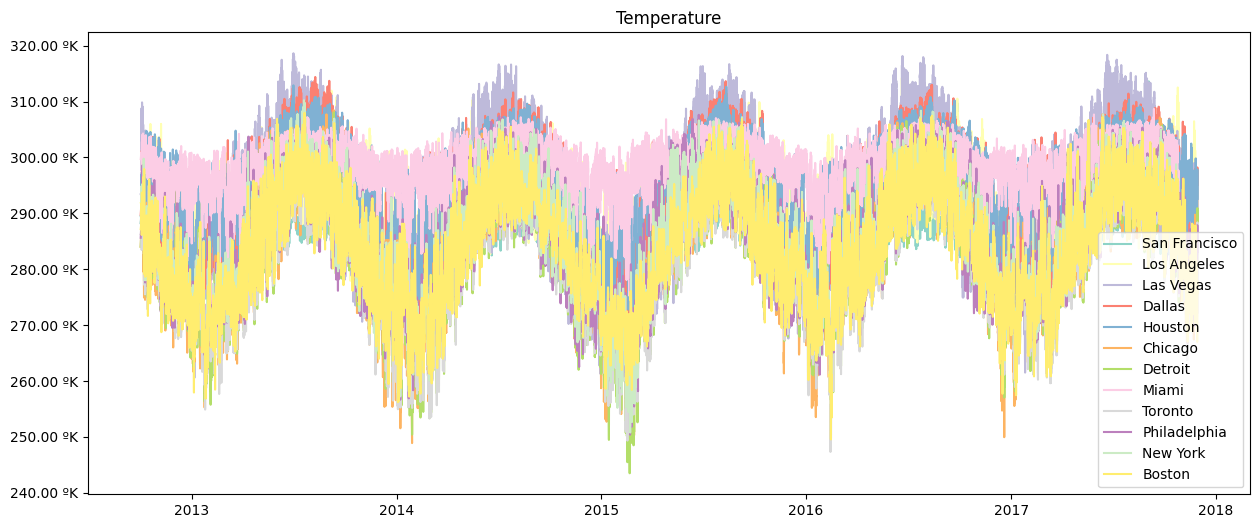

In [11]:
# Lets see how the temperature have evolved over time
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f ºK'))

for i in range(len(headers)):
  x = [initial_moment + datetime.timedelta(hours=j, minutes=0) for j  in range(ts_list_train[i].shape[0])]
  ax.plot(x, ts_list_train[i], label=headers[i], c=colors(i))

ax.legend()
ax.set_title('Temperature')
plt.show()


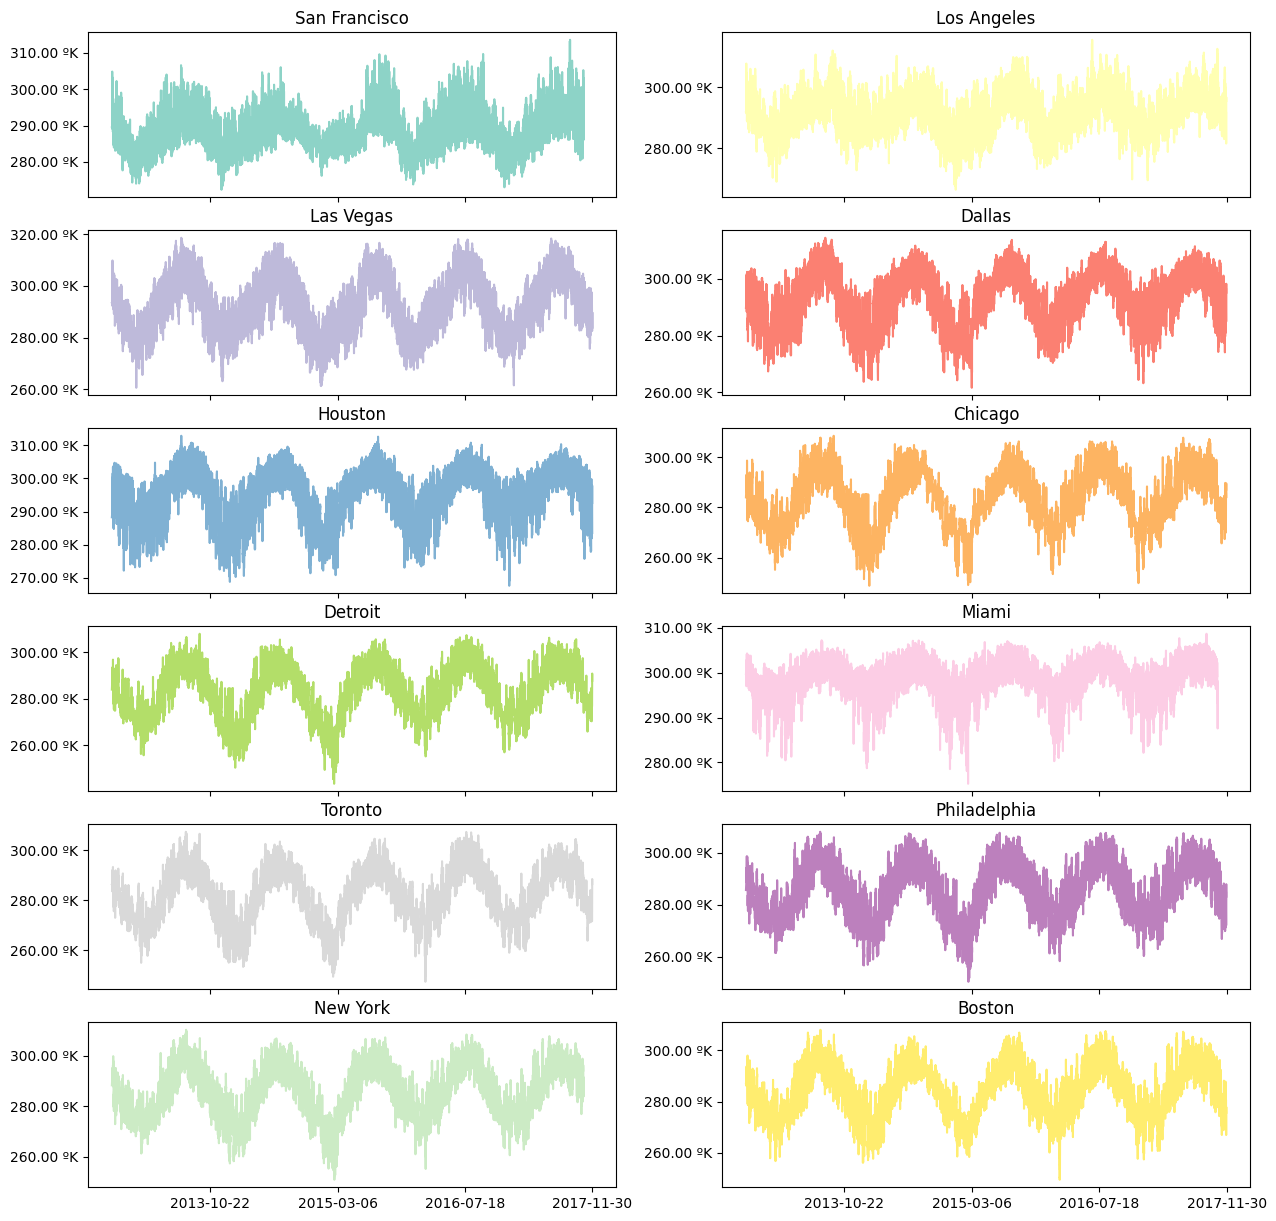

In [12]:
# Individual charts
fig, ax = plt.subplots(nrows=math.ceil(len(headers)/2), ncols=2, figsize=(15,15), sharex=True)

for i in range(len(headers)):
  x = [initial_moment + datetime.timedelta(hours=j, minutes=0) for j  in range(ts_list_train[i].shape[0])]
  ax[i//2][i%2].plot(x, ts_list_train[i], label=headers[i], c=colors(i))
  ax[i//2][i%2].set_title(headers[i])
  ax[i//2][i%2].yaxis.set_major_formatter(ticker.FormatStrFormatter('%1.2f ºK'))
  ax[i//2][i%2].xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()

# Preprocessing



It is important to scale features before training a neural network. Min-max normalization is a common way of doing this scaling.You could also use any other normalization method that rescales the values into a range of [0,1].

> MIN-MAX NORMALIZATION <br/>
$$X_{scaled} = \frac{x - x_{min}}{x_{max} - x_{min}} $$





In [13]:
def normalize(ts, norm_params):
  """
  Apply min-max normalization
  :param data: time series
  :param norm_params: tuple with params mean, std, max, min
  :return: normalized time series
  """
  return (ts - norm_params['min']) / (norm_params['max'] - norm_params['min'])

In [14]:
#Let's normalize the data.
ts_list_train_norm = []
# Save training norm params in order to use it for the test data 
norm_params_list = []

#for ts in ts_list_train:
for i, ts in enumerate(ts_list_train):
  norm_params = {}
  norm_params['city'] = headers[i][:6]
  norm_params['mean'] = np.round(ts.mean(),1)
  norm_params['std'] = np.round(ts.std(),1)
  norm_params['max'] = ts.max()
  norm_params['min'] = np.round(ts.min(),2)
  norm_params_list.append(norm_params)

  ts_norm = normalize(ts, norm_params)
  ts_list_train_norm.append(ts_norm)


In [15]:
norm_params_list

[{'city': 'San Fr', 'mean': 288.2, 'std': 5.3, 'max': 313.62, 'min': 272.3},
 {'city': 'Los An', 'mean': 290.8, 'std': 6.5, 'max': 315.47, 'min': 266.5},
 {'city': 'Las Ve', 'mean': 292.4, 'std': 10.8, 'max': 318.64, 'min': 260.56},
 {'city': 'Dallas', 'mean': 292.4, 'std': 9.5, 'max': 314.4, 'min': 261.61},
 {'city': 'Housto', 'mean': 294.2, 'std': 7.8, 'max': 312.91, 'min': 267.57},
 {'city': 'Chicag', 'mean': 283.4, 'std': 11.0, 'max': 308.48, 'min': 248.89},
 {'city': 'Detroi', 'mean': 283.0, 'std': 11.0, 'max': 308.05, 'min': 243.48},
 {'city': 'Miami', 'mean': 298.2, 'std': 4.2, 'max': 308.68, 'min': 275.23},
 {'city': 'Toront', 'mean': 281.9, 'std': 10.5, 'max': 307.28, 'min': 247.3},
 {'city': 'Philad', 'mean': 285.4, 'std': 10.2, 'max': 308.0, 'min': 250.39},
 {'city': 'New Yo', 'mean': 285.4, 'std': 10.2, 'max': 310.24, 'min': 250.77},
 {'city': 'Boston', 'mean': 283.8, 'std': 9.8, 'max': 308.0, 'min': 249.54}]

In [16]:
# Lets normalize the test data
ts_list_test_norm = []
for i, ts in enumerate(ts_list_test):
  norm_params = norm_params_list[i]
  ts_norm = normalize(ts, norm_params)
  ts_list_test_norm.append(ts_norm)


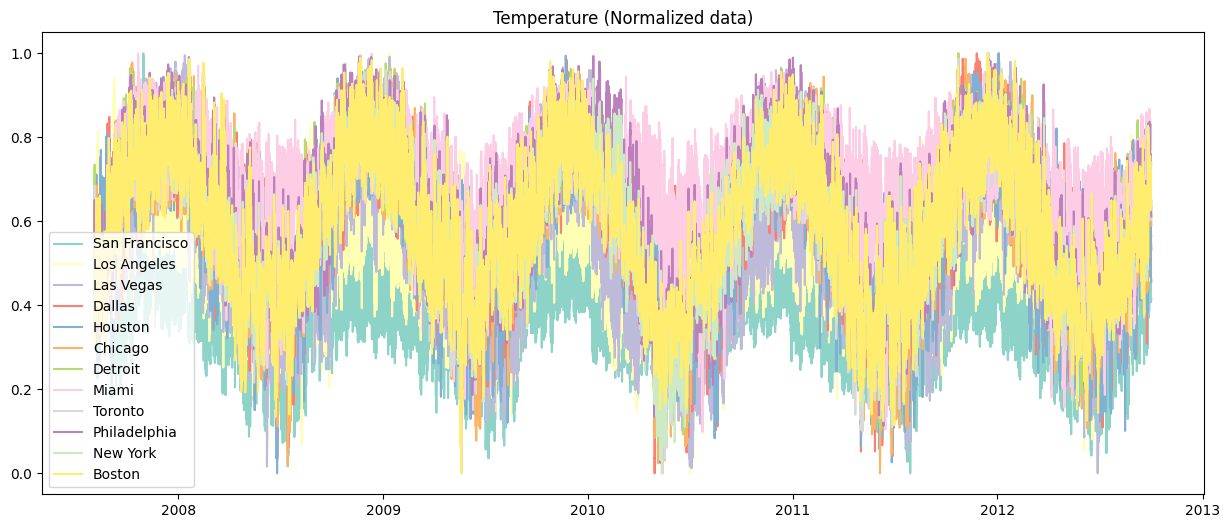

In [19]:
# This is how the time series look like now. 
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,6))

for i in range(len(headers)):
  x = [initial_moment - datetime.timedelta(hours=i, minutes=0) for i  in range(ts_list_train_norm[i].shape[0])]
  ax.plot(x, ts_list_train_norm[i], label=headers[i], c=colors(i))

ax.legend()
ax.set_title('Temperature (Normalized data)')
plt.show()

Let's now create the data for the model. The model will be given the last 240 hours (10 days) recorded temperature values, and needs to learn to predict the temperature for the next 24 hours (1 day). 

In [18]:
past_history = 240
forecast_horizon = 24


<img src="https://cdn-images-1.medium.com/max/1000/1*v5_QpzkQfufVogeCY9eaOw.png" alt="RNN data input" width="500"/>


In [19]:
# Moving window strategy

x_train, y_train = [], []
x_test, y_test = [], []

for i, ts in enumerate(ts_list_train_norm):
  # Train data
  ts_x_train, ts_y_train = [], []
  for j in range(0, ts.shape[0] - forecast_horizon + 1):
      indices = range(j - past_history, j, 1)
      # Reshape data from (past_history,) to (past_history, 1)
      ts_x_train.append(np.reshape(ts[indices], (past_history, 1)))
      ts_y_train.append(ts[j:j + forecast_horizon])
  x_train.extend(np.asarray(ts_x_train))
  y_train.extend(np.asarray(ts_y_train))
  # Test data
  ts_x_test = np.reshape(np.asarray(ts[-past_history:]), (past_history, 1))
  ts_y_test=  ts_list_test_norm[i]
  x_test.extend(np.asarray([ts_x_test]))
  y_test.extend(np.asarray([ts_y_test]))
  

x_train, y_train = np.asarray(x_train), np.asarray(y_train)
x_test, y_test = np.asarray(x_test), np.asarray(y_test, dtype='float32')

print("TRAINING DATA")
print("Input shape", x_train.shape)
print("Output_shape", y_train.shape)
print()
print("TEST DATA")
print("Input shape", x_test.shape)
print("Output_shape", y_test.shape)


TRAINING DATA
Input shape (540059, 240, 1)
Output_shape (540059, 24)

TEST DATA
Input shape (12, 240, 1)
Output_shape (12, 24)


In [49]:
total = 0
for i in ts_list_train:
    total += i.shape[0]
print(total)

540335


In [53]:
# Validation 
# Total(All observation) - 12 cities * ( 24 forecast horizon - 1 used to create the last training data) 
total - 12*(24-1)

540059

## Validation new tf. feature

In [13]:
# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

In [14]:
data = tf.range(1000)  # Example data, replace with your actual data
seq_length = 240
pred_length = 24

def split_input_target(sequence, pred_length):
    input_seq = sequence[:-pred_length]
    target_seq = sequence[-pred_length:]
    return input_seq, target_seq

In [37]:
ds = tf.keras.preprocessing.timeseries_dataset_from_array(
    data=data,
    targets=None,
    sequence_length=seq_length + pred_length,
    sequence_stride=1,
    batch_size=1
).map(lambda window: split_input_target(tf.squeeze(window), pred_length))

#ds = ds.unbatch().batch(1)  # Unbatch and batch again to ensure correct batch sizes
len(ds)

737

In [35]:
# Print the first few examples to verify
for batch in ds:
    inputs, targets = batch
    print("Inputs:", inputs.numpy())
    print("Targets:", targets.numpy())


Inputs: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239]
Targets: [240 241

continuar aca

In [61]:
seq_length = 240
pred_length = 24-1
total = 0
def split_input_target(sequence, pred_length):
    input_seq = sequence[:-pred_length]
    target_seq = sequence[-pred_length:]
    return input_seq, target_seq

for i, header in enumerate(headers):

    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=ts_list_train_norm[i],
        targets=None,
        sequence_length=seq_length + pred_length,
        sequence_stride=1,
        batch_size=1
    ).map(lambda window: split_input_target(tf.squeeze(window), pred_length))
    total += len(ds)
    
#ds = ds.unbatch().batch(1)  # Unbatch and batch again to ensure correct batch sizes
total

c:\Users\lenovo\Desktop\Forecast_TimeSeries\env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


537191

In [63]:
# The current difference is due to every city(12) is missed 240 observation
540059-537179 == 240*12

True

In [54]:
for present_values, next_value in ds:
    print(tf.squeeze(present_values).numpy(), '-->', next_value.numpy())
    x_train.append(present_values.numpy())
    y_train.append(next_value.numpy())

[[0.64368826 0.6439634  0.6447427  ... 0.5901473  0.6005815  0.6070818 ]
 [0.6439634  0.6447427  0.64552265 ... 0.6005815  0.6070818  0.61546344]
 [0.6447427  0.64552265 0.6463026  ... 0.6070818  0.61546344 0.629319  ]
 ...
 [0.6587769  0.65955675 0.66033614 ... 0.5677389  0.5571329  0.5453304 ]
 [0.65955675 0.66033614 0.66111606 ... 0.5571329  0.5453304  0.5391721 ]
 [0.66033614 0.66111606 0.66189545 ... 0.5453304  0.5391721  0.5290798 ]] --> [0.41566885 0.39069465 0.37256265 0.3612728  0.34690407 0.3385219
 0.32415318 0.31679785 0.30756062 0.3012316  0.29986337 0.2983239
 0.33390355 0.35614076 0.38658944 0.42798498 0.4473145  0.47092047
 0.48528922 0.4842629  0.4722887  0.4722887  0.44663012]


Visualize some examples

In [54]:
def show_plot(x, y, y_pred=None):
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-', c=colors(3), markersize=3.5, label='History')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colors(0), markersize=3.5, label='True Future')
  if y_pred is not None:
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colors(2), markersize=3.5, label='Model prediction')
  ax.legend()

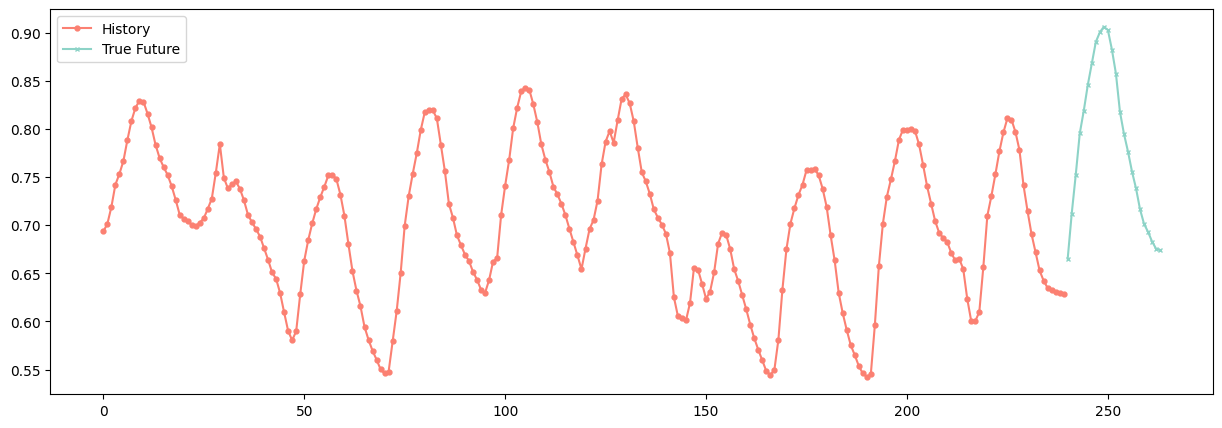

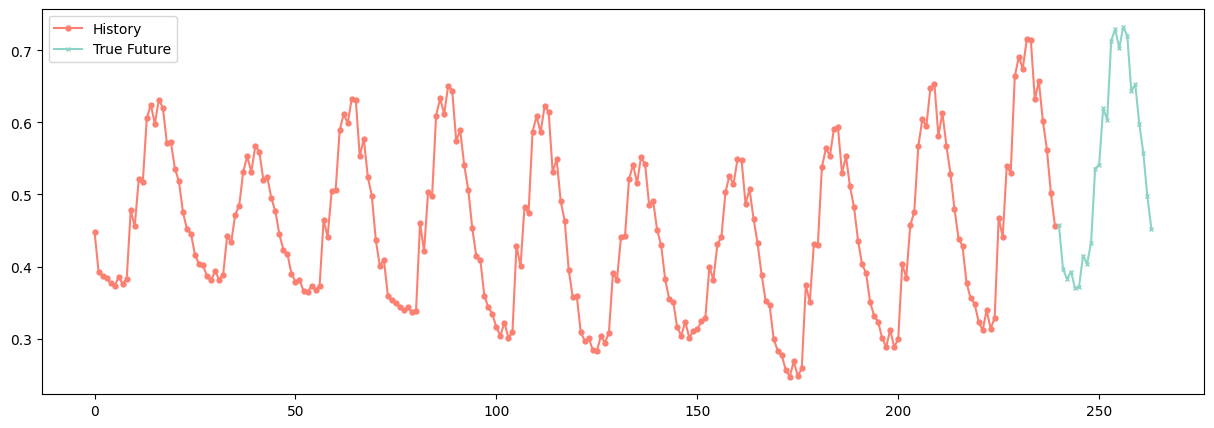

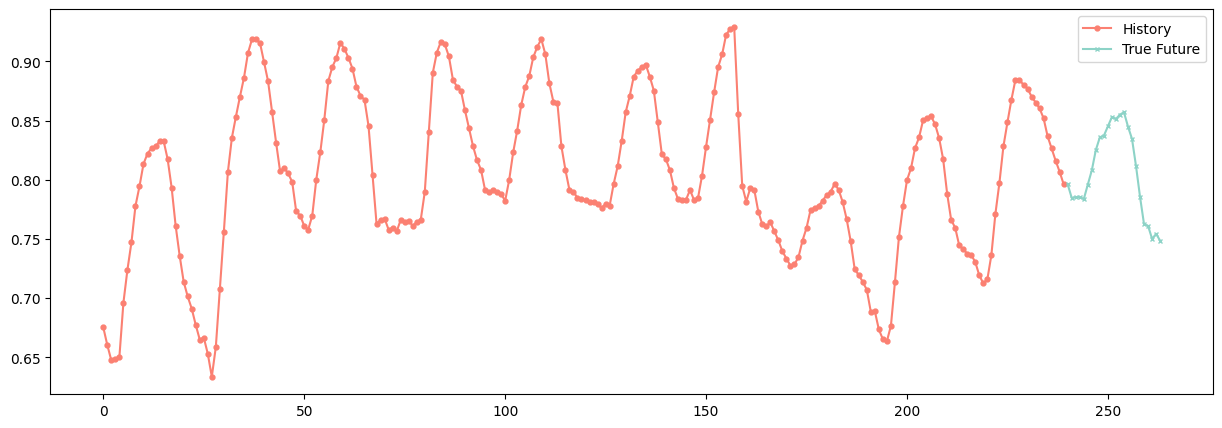

In [65]:
# Choosen random series
for _ in range(3):
  random_index = random.randint(0,x_train.shape[0])
  show_plot(x_train[random_index],y_train[random_index])


In [66]:
from collections import defaultdict
results = defaultdict(lambda: {})

# Long-Short Term Memory (LSTM) Neural Network 

In [67]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, LSTM, Input

In [68]:
# Create model with one LSTM layer with 64 units
inp = Input(shape=x_train.shape[-2:])
x = LSTM(64)(inp)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,456 (72.09 KB)

 Trainable params: 18,456 (72.09 KB)

 Non-trainable params: 0 (0.00 B)

Lets train the model

In [69]:
history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

c:\Users\lenovo\Desktop\Forecast_TimeSeries\env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5941s 3s/step - loss: 0.0795 - val_loss: 0.0613
Epoch 2/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5793s 3s/step - loss: 0.0417 - val_loss: 0.0624
Epoch 3/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5165s 2s/step - loss: 0.0407 - val_loss: 0.0588
Epoch 4/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 5866s 3s/step - loss: 0.0396 - val_loss: 0.0587
Epoch 5/5
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 6491s 3s/step - loss: 0.0390 - val_loss: 0.0577


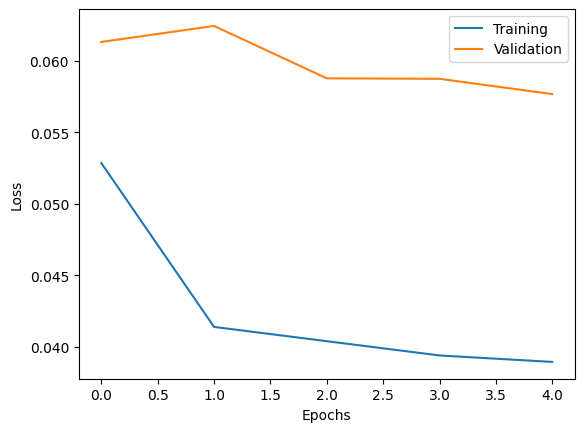

In [70]:
## Visualize training stats 
plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.show()

Let's see the predictions

In [71]:
predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['SimpleLSTM'] = mae
results['Y_PRED']['SimpleLSTM'] = predictions
pd.DataFrame(results)['MAE']

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


SimpleLSTM    0.057663
Name: MAE, dtype: float32

In [ ]:
for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

In [ ]:
# We can create a more-sofisticated model by stacking LSTM layers. 
inp = Input(shape=x_train.shape[-2:])
x = LSTM(64, return_sequences=True)(inp)
x = LSTM(32, return_sequences=False)(x)
x = Dense(64)(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['LSTM'] = mae
results['Y_PRED']['LSTM'] = predictions
print(pd.DataFrame(results)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

 # Gated Recurrent Unit (GRU) Network

In [20]:
# GRU
inp = Input(shape=x_train.shape[-2:])
x = GRU(128, return_sequences=True)(inp)
x = GRU(64, return_sequences=True)(x)
x = Flatten()(x)
x = Dense(64)(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['GRU'] = mae
results['Y_PRED']['GRU'] = predictions
print(pd.DataFrame(results)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 240, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 240, 128)       │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 240, 64)        │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15360)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       983,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,560 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,072,216 (4.09 MB)

 Trainable params: 1,072,216 (4.09 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/5
  64/2110 ━━━━━━━━━━━━━━━━━━━━ 1:19:46 2s/step - loss: 0.1794

# Temporal Convolutional Network (TCN)

In [ ]:
# TCN
inp = Input(shape=x_train.shape[-2:])
x = TCN(nb_filters=64, kernel_size=3, nb_stacks=1, dilations=[1,2,4,8,16,32,64])(inp)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['TCN'] = mae
results['Y_PRED']['TCN'] = predictions
print(pd.DataFrame(results)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

# Convolutional Neural Network (CNN)

In [ ]:
# CNN
inp = Input(shape=x_train.shape[-2:])
x = Conv1D(128, 7, activation='relu', padding='same')(inp)
x = MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Conv1D(64, 5, activation='relu', padding='same')(inp)
x = tf.keras.layers.MaxPool1D(pool_size=2)(x)
x = tf.keras.layers.Flatten()(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['CNN'] = mae
results['Y_PRED']['CNN'] = predictions
print(pd.DataFrame(results)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

# Multi-Layer Perceptron (MLP)

In [ ]:
# MLP
inp = Input(shape=x_train.shape[-2:])
x = Flatten()(inp)
x = Dense(128)(x)
x = Dense(64)(x)
x = Dense(32)(x)
x = Dense(forecast_horizon)(x)
model = keras.Model(inputs=inp, outputs=x)

model.compile(optimizer='adam', loss='mae')
print(model.summary())

history = model.fit(x_train, y_train,
          batch_size=256,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))

plt.figure()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])

predictions = model.predict(x_test)
mae = mean_absolute_error(y_test, predictions)
results['MAE']['MLP'] = mae
results['Y_PRED']['MLP'] = predictions
print(pd.DataFrame(results)['MAE'])

for x, y, y_pred in zip(x_test, y_test, predictions):
  show_plot(x,y,y_pred)

# Analysis of results

In [ ]:
pd.DataFrame(results)['MAE']

In [ ]:
for i, (x, y)  in enumerate(zip(x_test, y_test)):
  y_pred=None
  fig, ax = plt.subplots(1,1, figsize=(15,5))
  ax.plot(x, 'o-', c=colors(3), markersize=3.5, label='History')
  ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y, 'x-', c=colors(0), markersize=3.5, label='True Future')
  for j, (model_name, preds) in enumerate(results['Y_PRED'].items()): 
    y_pred = preds[i]
    ax.plot([m for m in range(x.shape[0],x.shape[0]+y.shape[0])], y_pred, 'o-', c=colors(2+j), alpha=0.7, markersize=3.5, label=model_name)
  ax.legend()